In [1]:
import xarray as xr
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import platform
import os

from shapely.geometry import Polygon, Point
from shapely.ops import transform
import pyproj

In [2]:
def point_in_polygon(lon, lat, polygon):
    point = Point(lon, lat)
    return polygon.contains(point)

In [12]:
Titulos = ['Demarcación marina levantino-balear', 'Demarcación marina noratlántica','Demarcación marina canaria', 
           'Demarcación sudatlántica','Demarcación Estrecho y Alborán']
Titulos_short = ['LEB', 'NOR','CAN','SUD','ESA']

In [29]:
i=2
titulo = Titulos[i]
titulo_short = Titulos_short[i]

In [63]:
# Load the data from the .txt file
longDem, latiDem = [], []
demCoord = []
with open('./LimiteDemarcaciones/Demarcacion'+titulo_short+'.txt', 'r') as f:
    for line in f:
        # Split the line by whitespace and append the values
        longitude, latitude = map(float, line.split())
        longDem.append(longitude)
        latiDem.append(latitude)
        demCoord.append((longitude+360,latitude))

In [64]:
demPolygon = Polygon(demCoord)

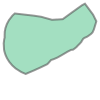

In [65]:
demPolygon

(338.1047195000042, 27.934948798171)

In [66]:
# Define a transformation to ensure the polygon's CRS matches
def transform_polygon(polygon, src_crs='epsg:4326', tgt_crs='epsg:4326'):
    # Transform the polygon to match the DataArray CRS if needed
    proj = pyproj.Transformer.from_proj(pyproj.Proj(src_crs), pyproj.Proj(tgt_crs), always_xy=True)
    return transform(lambda x, y: proj.transform(x, y), polygon)

In [81]:
demPolygon_transformed = transform_polygon(demPolygon)

In [68]:
if os.uname().nodename.lower().find('eemmmbp') != -1:
    base_file = '/Users/pvb/Dropbox/Oceanografia/Data/Satelite/noaa.oisst.v2.highres/NC/sst.day.mean'
elif os.uname().nodename.lower().find('rossby') != -1:
    base_file = '/data/shareddata/Satelite/noaa.oisst.v2.highres/NC/sst.day.mean'
    dataDir = '/home/pvb/Analisis/SSTGlobalAnalysis/data'
elif os.uname().nodename.lower().find('sagams') != -1:
    base_file = '/Users/pvb/Dropbox/Oceanografia/Data/Satelite/noaa.oisst.v2.highres/NC/sst.day.mean'
    dataDir = '/home/pvb/Analisis/SSTGlobalAnalysis/data'    

In [69]:
files = [f'{base_file}.{year}.nc' for year in range(year1, year2+1)]
DS = xr.open_mfdataset(files)

In [85]:
mask = np.array([ 
    [point_in_polygon(lon, lat, demPolygon_transformed) 
     for lon in DS.lon.values] 
     for lat in DS.lat.values])

In [90]:
DS = DS.where(mask)

In [91]:
if  titulo_short == 'LEB':
    sst = DS.sst.sel(lat=slice(36,43)).sel(lon=slice(0,6.5))
    print('>>>>> '+titulo)
elif  titulo_short == 'NOR':
    sst = DS.sst.sel(lat=slice(41.25,47)).sel(lon=slice(345.5,358.50))
    print('>>>>> '+titulo)
elif  titulo_short == 'CAN':
    sst = DS.sst.sel(lat=slice(24.3,32.5)).sel(lon=slice(337.75,349.75))
    print('>>>>> '+titulo)
elif  titulo_short == 'SUD':
    sst = DS.sst.sel(lat=slice(35.5,37.4)).sel(lon=slice(352,354.25))
    print('>>>>> '+titulo)
elif  titulo_short == 'ESA':
    sst = DS.sst.sel(lat=slice(35.6,37)).sel(lon=slice(354,358.25))
    print('>>>>> '+titulo)

>>>>> Demarcación marina canaria


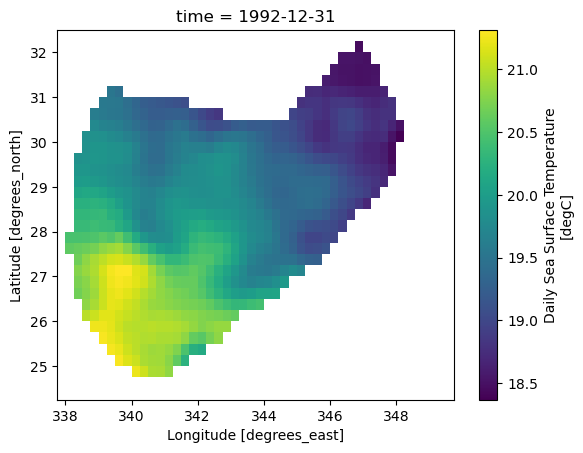

In [92]:
sst[-1,:,:].plot()

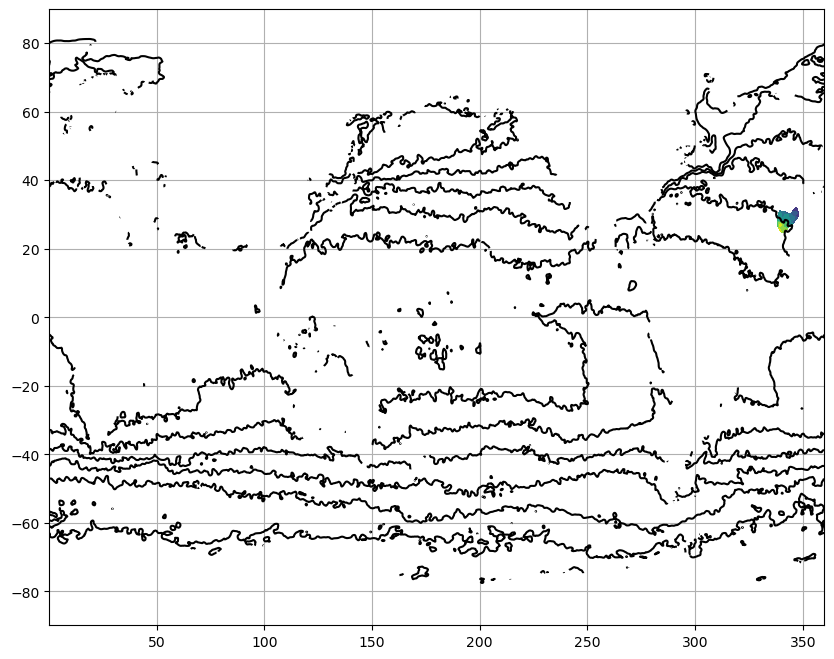

In [61]:
fig, ax = plt.subplots(1, 1 , figsize=(10,8))
ax.contour(DS.lon,DS.lat,DS.sst[-1,:,:],colors='k',levels=np.arange(0,35,5))
ax.contourf(masked_ds.lon,masked_ds.lat,masked_ds.sst[-1,:,:],)
ax.grid()

In [53]:
DS.lon

<xarray.DataArray 'lon' (lon: 1440)> Size: 6kB
array([1.25000e-01, 3.75000e-01, 6.25000e-01, ..., 3.59375e+02, 3.59625e+02,
       3.59875e+02], dtype=float32)
Coordinates:
  * lon      (lon) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
Attributes:
    long_name:      Longitude
    standard_name:  longitude
    units:          degrees_east
    actual_range:   [1.25000e-01 3.59875e+02]
    axis:           X